In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import kagglehub
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [185]:
# Download latest version
path = kagglehub.dataset_download("rakannimer/air-passengers")
dataset_path = f"{path}/AirPassengers.csv"
data = pd.read_csv(dataset_path)

# Check the structure of the data
print(data.head())

# Ensure the 'Month' column is parsed as datetime
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')

# Check the data info
print(data.info())

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB
None


In [186]:
# Rename data columns
data.columns = ['Month','Passengers']
data.set_index('Month', inplace=True)
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


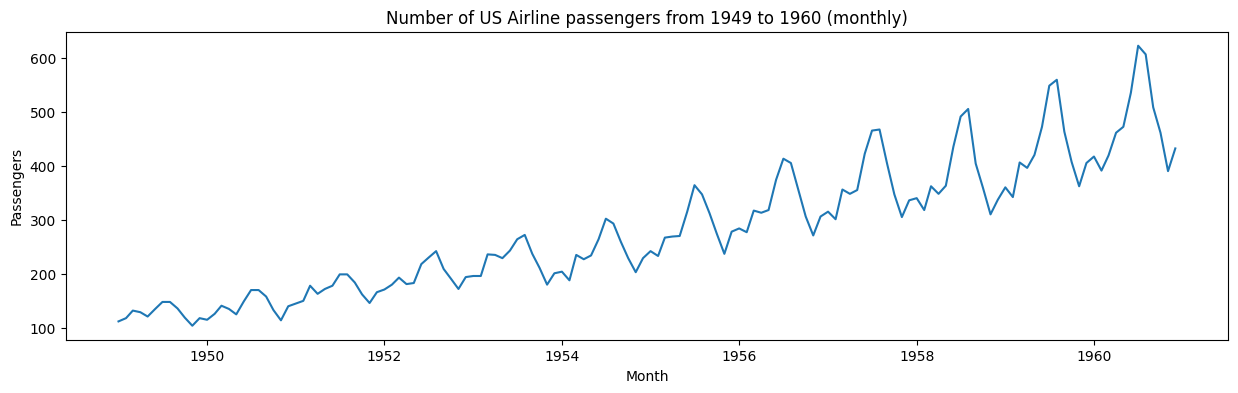

In [187]:
# Plot the time series
plt.figure(figsize=(15, 4))
plt.plot(data.index, data['Passengers'])
plt.title('Number of US Airline passengers from 1949 to 1960 (monthly)')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.show()

## Decomposition

Multiplicative decomposition is used when the seasonal variations in a time series change proportionally with the data's magnitude, making it suitable for datasets with nonlinear growth, such as airline passenger counts or sales figures. In contrast, additive decomposition assumes that seasonal variations remain constant over time, making it ideal for datasets with stable fluctuations, like temperature or consistent product sales. If the data exhibits increasing variance, a multiplicative model is preferable, while an additive model is better for stable patterns.

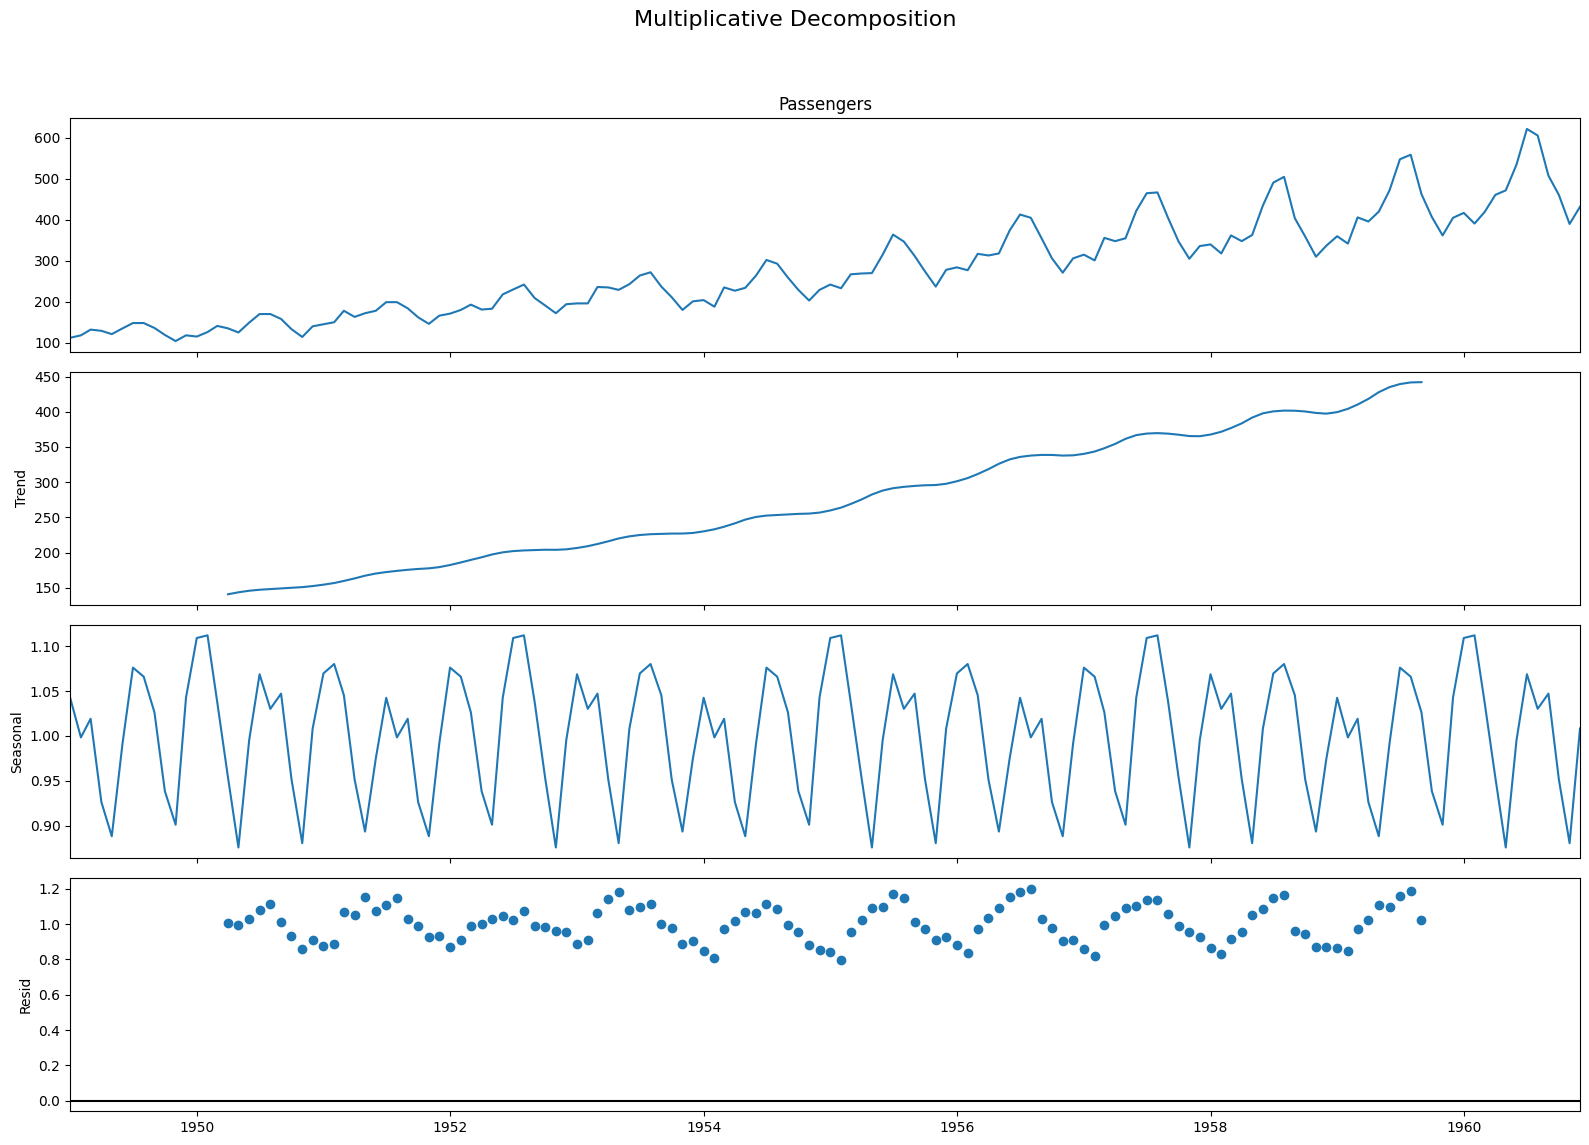

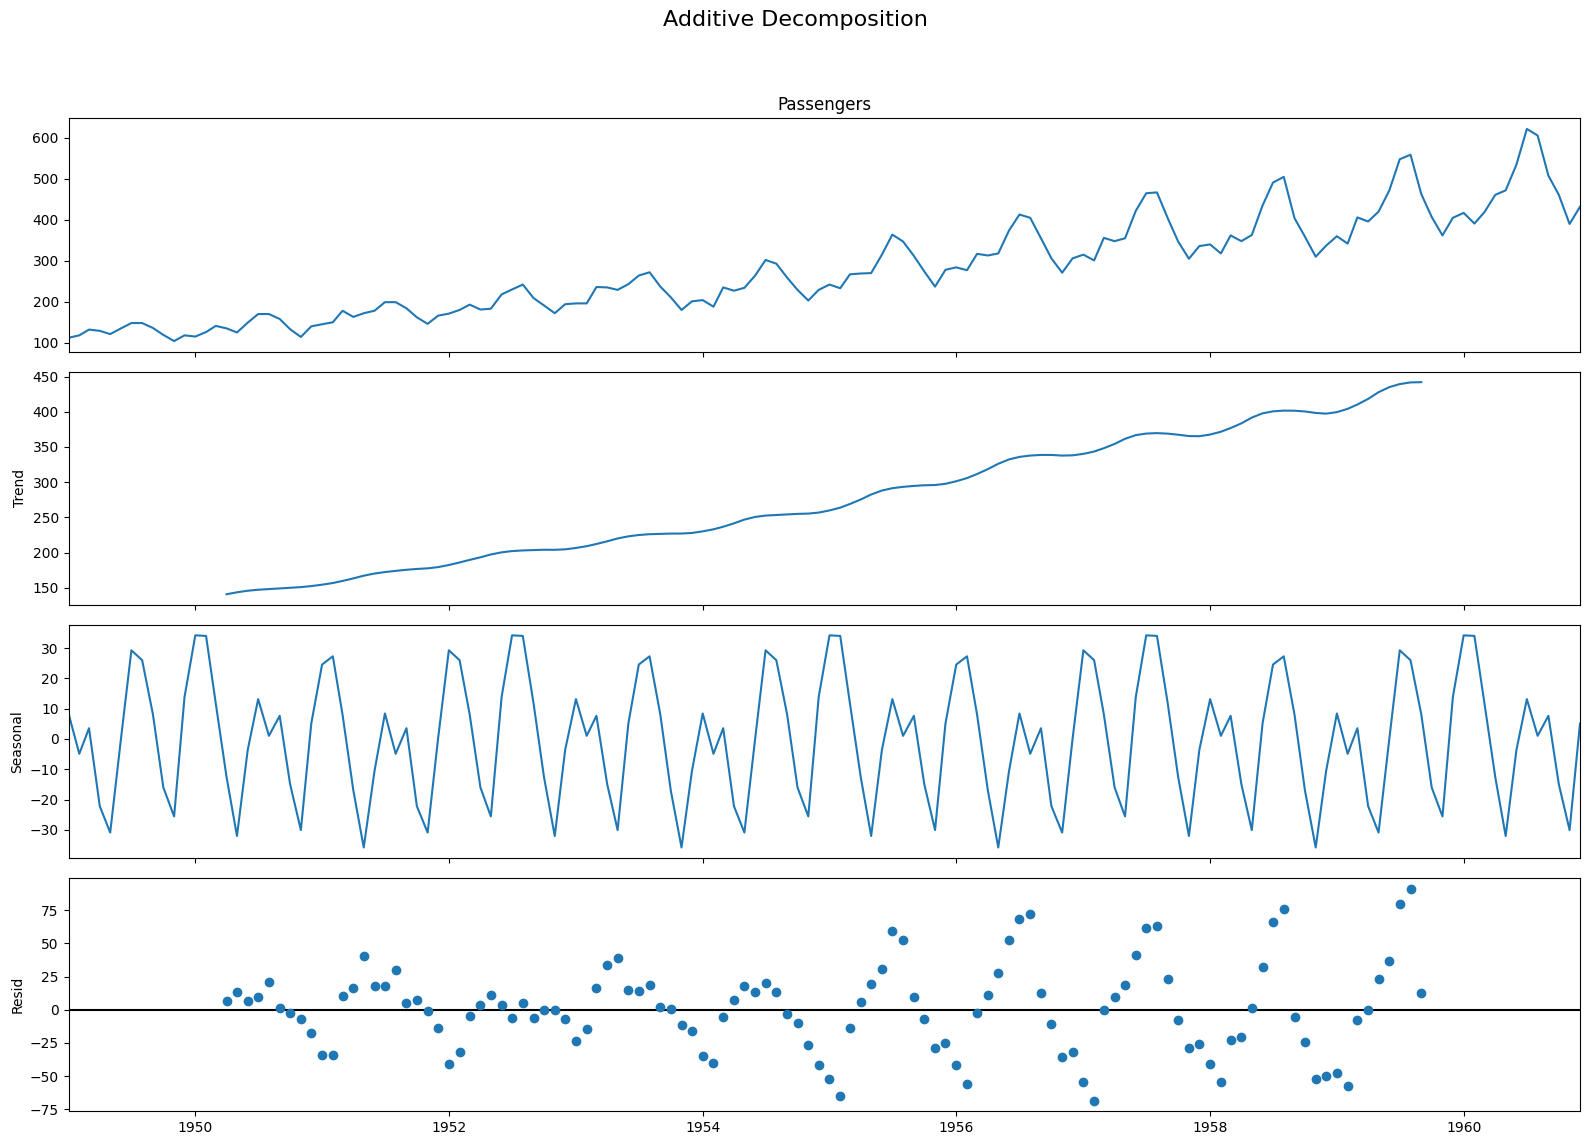

In [83]:
# Multiplicative Decomposition
multiplicative_decomposition = seasonal_decompose(data['Passengers'], model='multiplicative', period=30)

# Additive Decomposition
additive_decomposition = seasonal_decompose(data['Passengers'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Multiplicative Decomposition is more suitable for this dataset because the fluctuations increase as the data values grow, indicating that seasonal variations are proportional to the magnitude of the data. In contrast, Additive Decomposition assumes a constant seasonal variation over time, which does not align with this dataset's pattern. Therefore, the Multiplicative model better captures the increasing seasonal effects as the trend rises.

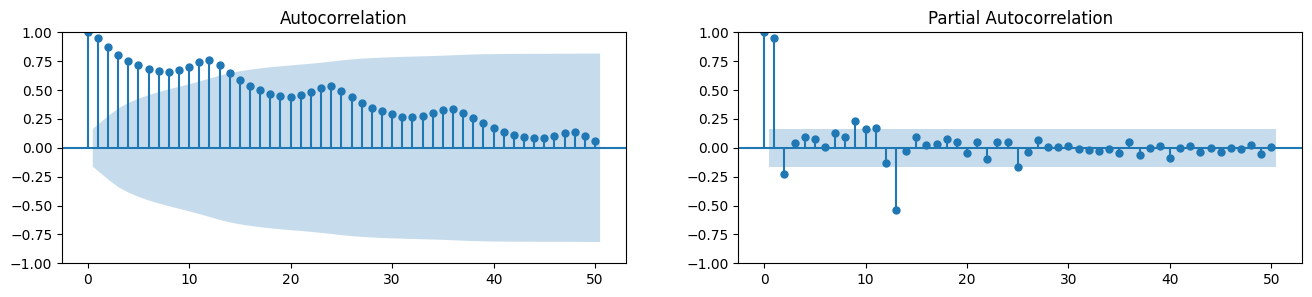

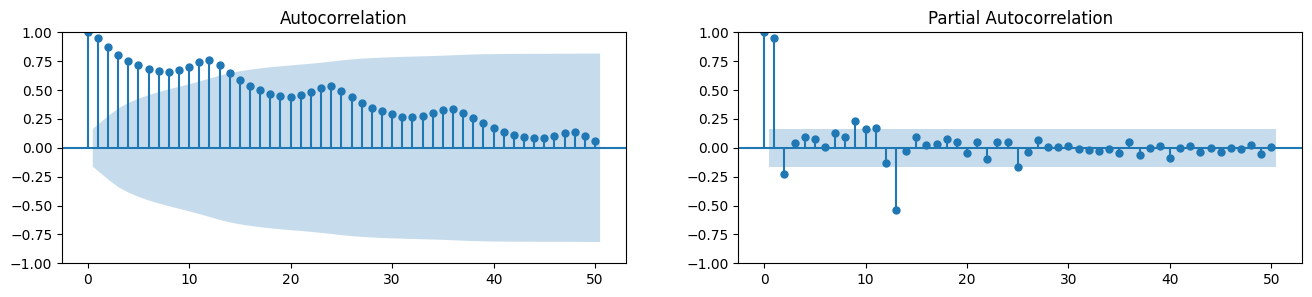

In [90]:
# Draw Autocorrelation and Partial Autocorrelation Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(data['Passengers'].tolist(), lags=50, ax=axes[0])
plot_pacf(data['Passengers'].tolist(), lags=50, ax=axes[1])

The ACF plot shows a slow decay, indicating that the time series has a long memory and is not stationary. The PACF plot exhibits significant spikes at early lags, suggesting that a few past values have a direct influence on the current value. This pattern is characteristic of an AutoRegressive (AR) process, where the current value is strongly influenced by its past values.

In [91]:
result = adfuller(data['Passengers'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("The data satisfies stationarity. Differencing is not required.")
else:
    print("The data does not satisfy stationarity. Differencing is required.")

ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641
The data does not satisfy stationarity. Differencing is required.


In [197]:
data_diff1 = data['Passengers'].diff().dropna()
result = adfuller(data_diff1)

print(f'ADF Statistic after 1st Differencing: {result[0]}')
print(f'p-value after 1st Differencing: {result[1]}')

if result[1] < 0.05:
    print("The data is stationary after first differencing.")
else:
    print("The data is still not stationary after first differencing. Further differencing may be required.")

data_seasonal_diff = data['Passengers'].diff(12).dropna()

result = adfuller(data_seasonal_diff)
print(f'ADF Statistic after Seasonal Differencing: {result[0]}')
print(f'p-value after Seasonal Differencing: {result[1]}')

if result[1] < 0.05:
    print("The data is stationary after seasonal differencing.")
else:
    print("The data is still not stationary after seasonal differencing.")

ADF Statistic after 1st Differencing: -2.6577793064862067
p-value after 1st Differencing: 0.0816335412763905
The data is still not stationary after first differencing. Further differencing may be required.
ADF Statistic after Seasonal Differencing: -3.1815239827661306
p-value after Seasonal Differencing: 0.021079363246058993
The data is stationary after seasonal differencing.


The ADF test was used to determine whether the time series is stationary, and the results confirmed that it is non-stationary. Differencing was applied, but the first-order differencing was not statistically significant, whereas the seasonally differenced time series was statistically significant.









ADF Statistic after 2nd Differencing: -15.834210484059657
p-value after 2nd Differencing: 9.862383904626322e-29
The data is stationary after second differencing.


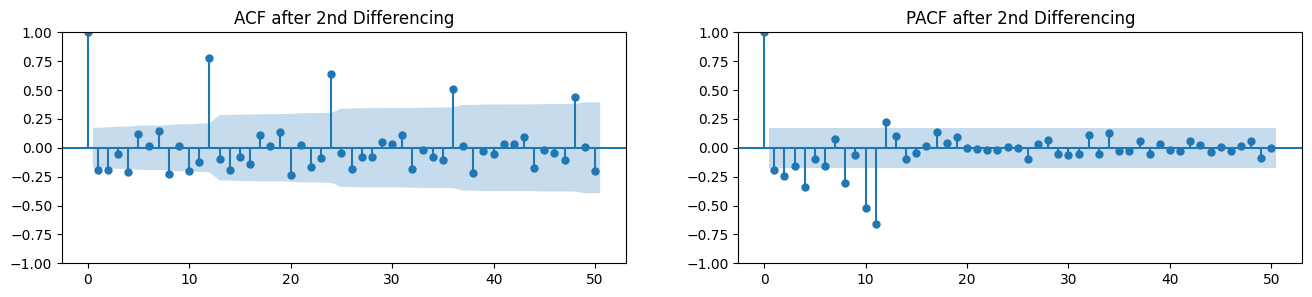

In [191]:
# Apply second differencing
data_diff2 = data['Passengers'].diff().diff().dropna()

# Perform ADF test after second differencing
result = adfuller(data_diff2)

print(f'ADF Statistic after 2nd Differencing: {result[0]}')
print(f'p-value after 2nd Differencing: {result[1]}')

if result[1] < 0.05:
    print("The data is stationary after second differencing.")
else:
    print("The data is still not stationary after second differencing. Further differencing may be needed.")

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 3), dpi=100)

plot_acf(data_diff2.tolist(), lags=50, ax=axes[0])
plot_pacf(data_diff2.tolist(), lags=50, ax=axes[1])

axes[0].set_title("ACF after 2nd Differencing")
axes[1].set_title("PACF after 2nd Differencing")

plt.show()


The second-order differencing results indicate that the time series has become stationary.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  133
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -638.349
Date:                Sun, 02 Mar 2025   AIC                           1282.698
Time:                        19:58:17   BIC                           1291.278
Sample:                    12-01-1949   HQIC                          1286.184
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3059      0.117      2.619      0.009       0.077       0.535
ma.L1         -1.0000    220.988     -0.005      0.996    -434.128     432.128
sigma2      1126.5533   2.49e+05      0.005      0.9

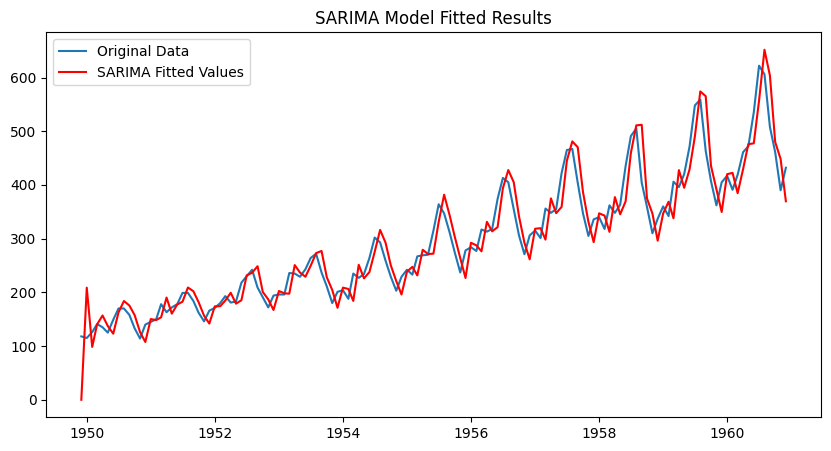

In [198]:
model = ARIMA(data['Passengers'],
                order=(1,2,1),       # Non-seasonal (p,d,q) # Seasonal (P,D,Q,s)
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
results = model.fit()

# Print the summary of the results
print(results.summary())

# Visualize the forecast results
plt.figure(figsize=(10,5))
plt.plot(data['Passengers'], label='Original Data')
plt.plot(results.fittedvalues, color='red', label='SARIMA Fitted Values')
plt.legend()
plt.title("SARIMA Model Fitted Results")
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  133
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -415.503
Date:                            Sun, 02 Mar 2025   AIC                            841.005
Time:                                    19:58:43   BIC                            854.322
Sample:                                12-01-1949   HQIC                           846.403
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7164      0.090      7.958      0.000       0.540       0.893
ma.L1         -0.9738      0.050   

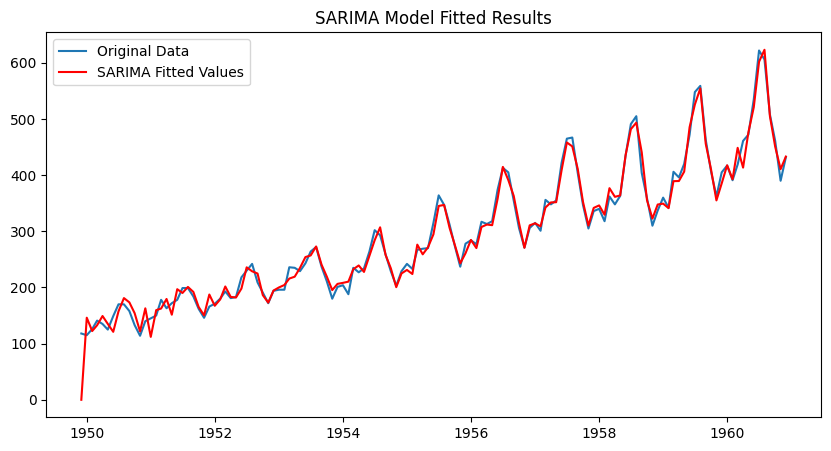

In [199]:
# Set up the SARIMA model (p,d,q) x (P,D,Q,s)
model = SARIMAX(data['Passengers'],
                order=(1,1,1),       # Non-seasonal (p,d,q)
                seasonal_order=(1,1,1,12),  # Seasonal (P,D,Q,s)
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
results = model.fit()

# Print the summary of the results
print(results.summary())

# Visualize the forecast results
plt.figure(figsize=(10,5))
plt.plot(data['Passengers'], label='Original Data')
plt.plot(results.fittedvalues, color='red', label='SARIMA Fitted Values')
plt.legend()
plt.title("SARIMA Model Fitted Results")
plt.show()

The number of differencing steps required to achieve stationarity was determined, and both ARIMA and SARIMA models were applied. The results showed that SARIMA had higher log-likelihood and lower AIC and BIC values, indicating a better fit compared to ARIMA.

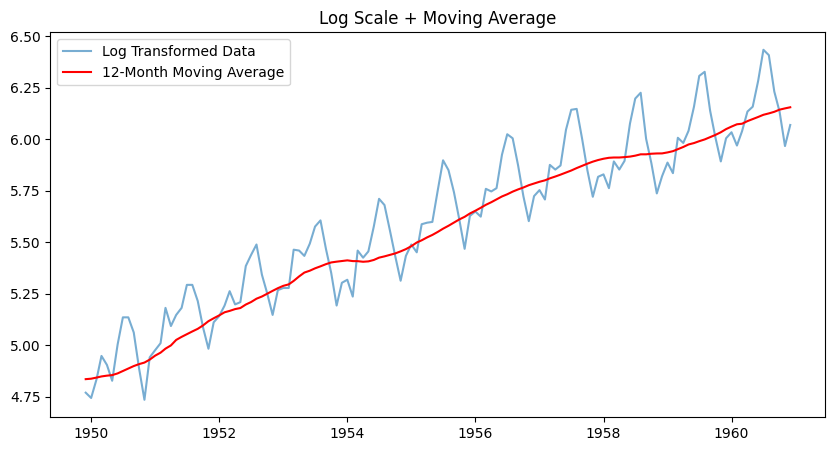

In [188]:
# Log Transformation (Log Scale)
data['Log_Passengers'] = np.log(data['Passengers'])

# Calculate Moving Average (12-month window)
data['Rolling_Mean_12'] = data['Log_Passengers'].rolling(window=12).mean()
data.dropna(inplace=True)

# Visualization (Original Log Transformed Data vs Moving Average)
plt.figure(figsize=(10,5))
plt.plot(data['Log_Passengers'], label='Log Transformed Data', alpha=0.6)
plt.plot(data['Rolling_Mean_12'], label='12-Month Moving Average', color='red')
plt.legend()
plt.title("Log Scale + Moving Average")
plt.show()

In [182]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Fit the SARIMAX model
model = SARIMAX(data['Log_Passengers'],
                order=(1,1,1),       # Non-seasonal (p,d,q)
                seasonal_order=(1,1,1,12),  # Seasonal (P,D,Q,s)
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

print(results.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                     Log_Passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 218.517
Date:                            Sun, 02 Mar 2025   AIC                           -427.035
Time:                                    18:39:23   BIC                           -413.224
Sample:                                01-01-1949   HQIC                          -421.428
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1016      0.203      0.502      0.616      -0.296       0.499
ma.L1         -0.5549      0.179   

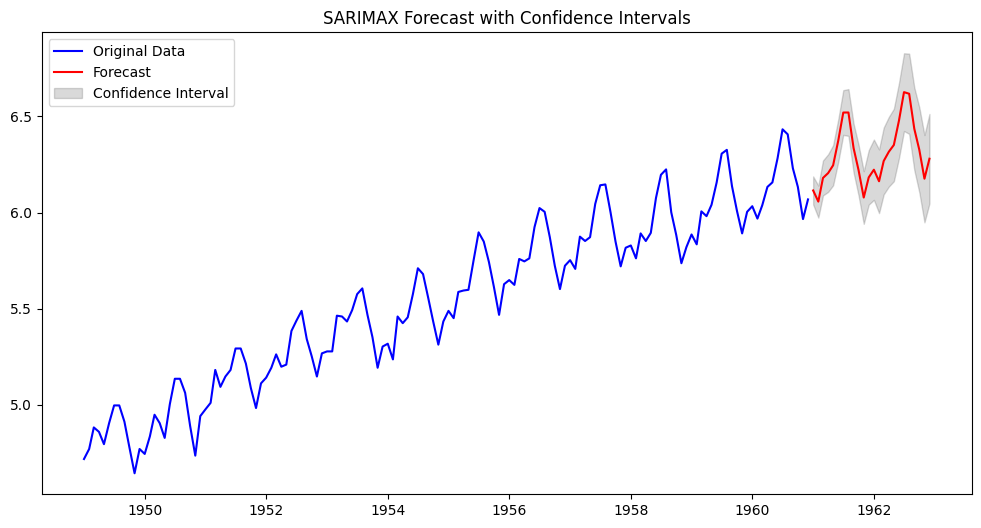

In [181]:
#Set the forecast period (24 months forecast)
n_periods = 24
forecast = results.get_forecast(steps=n_periods)

#Get forecast values and confidence intervals
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

#Set the date index for the forecast
forecast_index = pd.date_range(start=data.index[-1], periods=n_periods+1, freq='MS')[1:]

#Confidence interval lower & upper bounds
lower_series = confidence_intervals.iloc[:, 0]
upper_series = confidence_intervals.iloc[:, 1]

#Visualize the forecast results
plt.figure(figsize=(12,6))
plt.plot(data['Log_Passengers'], label='Original Data', color='blue')
plt.plot(forecast_index, forecast_values, color='red', label='Forecast')
plt.fill_between(forecast_index, lower_series, upper_series, color='k', alpha=0.15, label="Confidence Interval")

plt.legend()
plt.title("SARIMAX Forecast with Confidence Intervals")
plt.show()

By applying log scale transformation and moving average smoothing, we observed an improvement in log-likelihood, AIC, and BIC, leading to a more stable and reliable forecasting model. This enhancement is reflected in the graph, where the original data is shown in blue, the forecast in red, and the confidence interval in gray, representing the expected range of future values.